# TMVA Higgs Classification in Python
In this example we will still do Higgs classification but we will use together with the native TMVA methods also methods from Keras and scikit-learn.

### Import the necessary modules

We start with importing the necessary modules required for the tutorial. Here we imported ROOT and TMVA(Toolkit for Multivariate Data Analysis). If you want to know more about TMVA, you can refer the documentation.

In [17]:
import ROOT
from ROOT import TMVA


## Classification example of TMVA based on public Higgs UCI dataset
The UCI data set is a public HIGGS data set , see http://archive.ics.uci.edu/ml/datasets/HIGGS
used in this paper: Baldi, P., P. Sadowski, and D. Whiteson. “Searching for Exotic Particles in High-energy Physics with Deep Learning.” Nature Communications 5 (July 2, 2014).

In [18]:
# options to control used methods

useLikelihood = True       #likelihood based discriminant
useLikelihoodKDE = False   #likelihood based discriminant
useFischer = True          #Fischer discriminant
useMLP = False             #Multi Layer Perceptron (old TMVA NN implementation)
useBDT = True              #BOosted Decision Tree
useDL = True               #TMVA Deep learning ( CPU or GPU)

### Setting up TMVA

TMVA requires initialization the PyMVA to utilize PyTorch. PyMVA is the interface for third-party MVA tools based on Python. It is created to make powerful external libraries easily accessible with a direct integration into the TMVA workflow. All PyMVA methods provide the same plug-and-play mechanisms as the TMVA methods. Because the base method of PyMVA is inherited from the TMVA base method, all options of internal TMVA methods apply for PyMVA methods as well.

In [19]:
ROOT.TMVA.Tools.Instance()


### Create an Output File and Declare Factory

Create the Factory class. Later you can choose the methods whose performance you'd like to investigate.

The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

- The first argument is the base of the name of all the output weightfiles in the directory weight/ that will be created with the method parameters

- The second argument is the output file for the training results

- The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string



In [20]:

outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

### Define the input datafile

Take the input of the .root file in a variable if file exists. If the file doesn't exist, then download it through Cern box.

In [21]:
inputFileName = "Higgs_data.root"

inputFile = ROOT.TFile.Open( inputFileName )
inputFileLink = "http://root.cern.ch/files/" + inputFileName


if (ROOT.gSystem.AccessPathName(inputFileName)!=None):
    # file exists
    inputFile = ROOT.TFile.Open( inputFileName )
if(inputFile == None): 
    # download file from Cernbox location
    ROOT.Info("TMVA_Higgs_Classification","Download Higgs_data.root file")
    ROOT.TFile.SetCacheFileDir(".")
    inputFile = ROOT.TFile.Open(inputFileLink, "CACHEREAD")
    if (inputFile == NULL):
        Error("TMVA_Higgs_Classification","Input file cannot be downloaded - exit")


### Setting up the Signal and Background Trees

Here we are setting up the Training and testing Trees.

In [22]:
# --- Register the training and test trees

signalTree = inputFile.Get("sig_tree")
backgroundTree = inputFile.Get("bkg_tree")

signalTree.Print()


******************************************************************************
*Tree    :sig_tree  : tree                                                   *
*Entries :    10000 : Total =         1177229 bytes  File  Size =     785298 *
*        :          : Tree compression factor =   1.48                       *
******************************************************************************
*Br    0 :Type      : Type/F                                                 *
*Entries :    10000 : Total  Size=      40556 bytes  File Size  =        307 *
*Baskets :        1 : Basket Size=    1500672 bytes  Compression= 130.54     *
*............................................................................*
*Br    1 :lepton_pT : lepton_pT/F                                            *
*Entries :    10000 : Total  Size=      40581 bytes  File Size  =      30464 *
*Baskets :        1 : Basket Size=    1500672 bytes  Compression=   1.32     *
*...................................................

### Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input variables

Define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [23]:

loader = TMVA.DataLoader("dataset")

loader.AddVariable("m_jj")
loader.AddVariable("m_jjj")
loader.AddVariable("m_lv")
loader.AddVariable("m_jlv")
loader.AddVariable("m_bb")
loader.AddVariable("m_wbb")
loader.AddVariable("m_wwbb")

### We set now the input data trees in the TMVA DataLoader class

# global event weights per tree (see below for setting event-wise weights)
signalWeight = 1.0
backgroundWeight = 1.0

#  You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signalTree,     signalWeight     )
loader.AddBackgroundTree( backgroundTree, backgroundWeight )


DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events


Set individual event weights (the variables must exist in the original TTree)

for signal    : factory.SetSignalWeightExpression    ("weight1*weight2")

for background: factory.SetBackgroundWeightExpression("weight1*weight2")

loader.SetBackgroundWeightExpression( "weight" )


In [24]:

# Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("") # for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1"
mycutb = ROOT.TCut("") # for example: TCut mycutb = "abs(var1)<0.5"


### Tell the factory how to use the training and testing events

In [25]:

# If no numbers of events are given, half of the events in the tree are used
# for training, and the other half for testing:
#    loader.PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" )
# To also specify the number of testing events, use:

loader.PrepareTrainingAndTestTree( mycuts, mycutb, "nTrain_Signal=7000:nTrain_Background=7000:SplitMode=Random:NormMode=NumEvents:!V" )

### Booking Methods

Here we book the TMVA methods. We book first a Likelihood based on KDE (Kernel Density Estimation), a Fischer discriminant, a BDT
and a shallow neural network

In [26]:
# Likelihood ("naive Bayes estimator")
if (useLikelihood):
   factory.BookMethod(loader, ROOT.TMVA.Types.kLikelihood, "Likelihood",
                           "H:!V:TransformOutput:PDFInterpol=Spline2:NSmoothSig[0]=20:NSmoothBkg[0]=20:NSmoothBkg[1]=10:NSmooth=1:NAvEvtPerBin=50" )

# Use a kernel density estimator to approximate the PDFs
if (useLikelihoodKDE):
   factory.BookMethod(loader, ROOT.TMVA.Types.kLikelihood, "LikelihoodKDE",
                      "!H:!V:!TransformOutput:PDFInterpol=KDE:KDEtype=Gauss:KDEiter=Adaptive:KDEFineFactor=0.3:KDEborder=None:NAvEvtPerBin=50" )

# Fisher discriminant (same as LD)
if (useFischer):
   factory.BookMethod(loader, ROOT.TMVA.Types.kFisher, "Fisher", "H:!V:Fisher:VarTransform=None:CreateMVAPdfs:PDFInterpolMVAPdf=Spline2:NbinsMVAPdf=50:NsmoothMVAPdf=10" )


# Boosted Decision Trees
if (useBDT):
   factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
                      "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" )


# Multi-Layer Perceptron (Neural Network)
if (useMLP):
   factory.BookMethod(loader, ROOT.TMVA.Types.kMLP, "MLP",
                      "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=100:HiddenLayers=N+5:TestRate=5:!UseRegulator" )


Factory                  : Booking method: Likelihood
                         : 
Factory                  : Booking method: Fisher
                         : 
Factory                  : Booking method: BDT
                         : 
                         : Rebuilding Dataset dataset
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree sig_tree
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree bkg_tree
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 7000
                         : 

   ### Booking Deep Neural Network

   Here we define the option string for building the Deep Neural network model.

   #### 1. Define DNN layout

   The DNN configuration is defined using a string. Note that whitespaces between characters are not allowed.

   We define first the DNN layout:

   - **input layout** :   this defines the input data format for the DNN as  ``input depth | height | width``.
      In case of a dense layer as first layer the input layout should be  ``1 | 1 | number of input variables`` (features)
   - **batch layout**  : this defines how are the input batch. It is related to input layout but not the same.
      If the first layer is dense it should be ``1 | batch size ! number of variables`` (features)

      *(note the use of the character `|` as  separator of  input parameters for DNN layout)*

   note that in case of only dense layer the input layout could be omitted but it is required when defining more
   complex architectures

   - **layer layout** string defining the layer architecture. The syntax is
      - layer type (e.g. DENSE, CONV, RNN)
      - layer parameters (e.g. number of units)
      - activation function (e.g  TANH, RELU,...)

      *the different layers are separated by the ``","`` *

   #### 2. Define Training Strategy

   We define here the training strategy parameters for the DNN. The parameters are separated by the ``","`` separator.
   One can then concatenate different training strategy with different parameters. The training strategy are separated by
   the ``"|"`` separator.

   - Optimizer
   - Learning rate
   - Momentum (valid for SGD and RMSPROP)
   - Regularization and Weight Decay
   - Dropout
   - Max number of epochs
   - Convergence steps. if the test error will not decrease after that value the training will stop
   - Batch size (This value must be the same specified in the input layout)
   - Test Repetitions (the interval when the test error will be computed)


   #### 3. Define general DNN options

   We define the general DNN options concatenating in the final string the previously defined layout and training strategy.
   Note we use the ``":"`` separator to separate the different higher level options, as in the other TMVA methods.
   In addition to input layout, batch layout and training strategy we add now:

   - Type of Loss function (e.g. CROSSENTROPY)
   - Weight Initizalization (e.g XAVIER, XAVIERUNIFORM, NORMAL )
   - Variable Transformation
   - Type of Architecture (e.g. CPU, GPU, Standard)

   We can then book the DL method using the built option string

In [27]:
## Here we book the new DNN of TMVA if we have support in ROOT. We will use GPU version if ROOT is enabled with GPU

# Define DNN layout
inputLayoutString = "InputLayout=1|1|7"
batchLayoutString= "BatchLayout=1|32|7"
layoutString= "Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR"
# Define Training strategies
# one can catenate several training strategies
training1  = "Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,"
training1 += "DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1"
#      training2 = ROOT.TString("LearningRate=1e-3,Momentum=0.9"
#                       "ConvergenceSteps=10,BatchSize=128,TestRepetitions=1,"
#                       "MaxEpochs=20,WeightDecay=1e-4,Regularization=None,"
#                       "Optimizer=SGD,DropConfig=0.0+0.0+0.0+0.");

trainingStrategyString = "TrainingStrategy="
trainingStrategyString += training1 # + "|" + training2


In [28]:
#  General Options.

dnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:"+"WeightInitialization=XAVIER"

dnnOptions +=  ":" + inputLayoutString
dnnOptions +=  ":" + batchLayoutString
dnnOptions +=  ":" + layoutString
dnnOptions +=  ":" + trainingStrategyString

dnnMethodName = "DNN_CPU"


### Booking a Method

In [29]:
factory.BookMethod(loader, ROOT.TMVA.Types.kDL, dnnMethodName, dnnOptions)

Factory                  : Booking method: DNN_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER:InputLayout=1|1|7:BatchLayout=1|32|7:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER:InputLayout=1|1|7:BatchLayout=1|32|7

### Training All Methods

Here we train all the previously booked methods.

In [30]:
factory.TrainAllMethods()

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
TFHandler_Factory        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
         

### Test all methods

Now we test  all methods using the test data set

In [31]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: Likelihood for Classification performance
                         : 
Likelihood               : [dataset] : Evaluation of Likelihood on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.0102 sec       
Factory                  : Test method: Fisher for Classification performance
                         : 
Fisher                   : [dataset] : Evaluation of Fisher on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.00115 sec       
                         : Dataset[dataset] : Evaluation of Fisher on testing sample
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.0465 sec       
Factory

### Evaluate all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file


In [32]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: Likelihood
                         : 
Likelihood               : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_Likelihood     : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     m_jj:     1.0447    0.66216   [    0.14661     10.222 ]
                         :    m_jjj:     1.0275    0.37015   [    0.34201     5.6016 ]
                         :     m_lv:     1.0500    0.15582   [    0.29757     2.8989 ]
                         :    m_jlv:     1.0053    0.39478   [    0.41660     5.8799 ]
                         :     m_bb:    0.97464    0.52138   [    0.10941     5.5163 ]
                         :    m_wbb:     1.0296    0.35719   [    0.38878     3.9747 ]
                         :   m_w

### Plot ROC Curve
Here we plot the ROC curve and display the same.

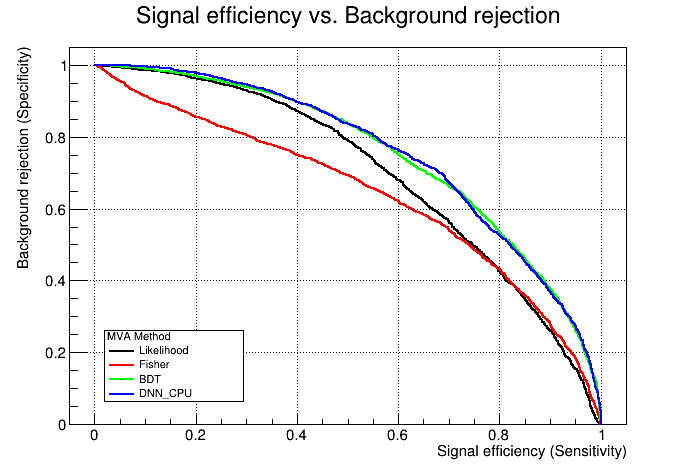

In [33]:
## after we get the ROC curve and we display

c1 = factory.GetROCCurve(loader)
c1.Draw()

### Close the Output File
Close outputfile to save all output information (evaluation result of methods) and it can be used by TMVAGUI to display additional plots

In [34]:

outputFile.Close()
